# Using batch prediction feature with Keras models on Cloud AI Platform

**Note: use "TensorFlow Enterprise 2.3" instance to run this notebook.**

Define environment variables and create a strage bucket.

In [1]:
# change these to try this notebook out
BUCKET = 'enakai-ml-pipeline'
PROJECT = 'enakai-ml-pipeline'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

Creating gs://enakai-ml-pipeline/...


Import modules and prepare training data. (You use the Titaic data as a simple example.)

In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/enakai00/numpy-pandas-tutorial/master/titanic.csv')
data['pclass'] = data['pclass'].astype(str)

In [7]:
tmp = data[['age', 'sex', 'fare', 'pclass', 'survived']].dropna()
X_ = tmp[['age', 'sex', 'fare', 'pclass']]
y = tmp['survived']
X = pd.get_dummies(X_)
X.head()

,age,fare,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,29.00,211.3375,1,0,1,0,0
1,0.92,151.5500,0,1,1,0,0
2,2.00,151.5500,1,0,1,0,0
3,30.00,151.5500,0,1,1,0,0
4,25.00,151.5500,1,0,1,0,0


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

Create a model to predict the 'survival probablity' and train it.

In [9]:
model = models.Sequential()
model.add(Input(shape=(7,), name='features'))#, dtype=tf.float64))
model.add(layers.Dense(8, activation='relu', name='hidden'))
model.add(layers.Dense(1, activation='sigmoid', name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 8)                 64        
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    batch_size=64, epochs=50, verbose=0)

<AxesSubplot:>

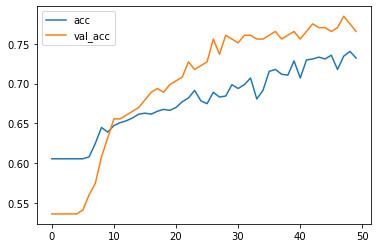

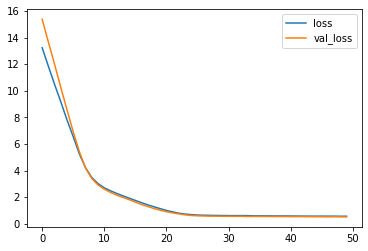

In [12]:
DataFrame({'acc': history.history['acc'], 
           'val_acc': history.history['val_acc']}).plot()
DataFrame({'loss': history.history['loss'], 
           'val_loss': history.history['val_loss']}).plot()

Create a wrapper model so that you can add an identifier key to each example.

In [13]:
key_raw = tf.keras.layers.Input(shape=(), name='key', dtype='int32')
key = tf.keras.layers.Reshape((1,), input_shape=(), dtype='int32')(key_raw)
pred = tf.keras.layers.Concatenate(name='survival_and_key')([model.output, tf.cast(key, tf.float32)])
wrapper_model = Model(inputs=[model.input, key_raw], outputs=pred)
wrapper_model.compile()
wrapper_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
key (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
hidden (Dense)                  (None, 8)            64          features[0][0]                   
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1)            0           key[0][0]                        
_______________________________________________________________________________________

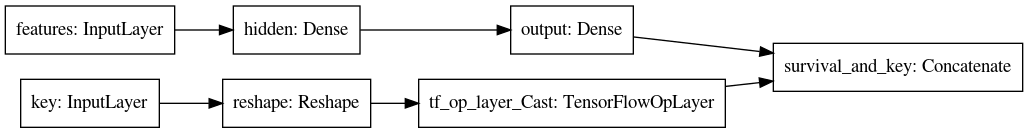

In [14]:
tf.keras.utils.plot_model(
    model=wrapper_model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

Use the predict method of the wrapper model.

In [15]:
wrapper_model.predict([X_val[:10], tf.constant(range(10))])

array([[0.09080863, 0.        ],
       [0.8593658 , 1.        ],
       [0.8139764 , 2.        ],
       [0.28496954, 3.        ],
       [0.6556365 , 4.        ],
       [0.40990826, 5.        ],
       [0.925493  , 6.        ],
       [0.31326413, 7.        ],
       [0.7235092 , 8.        ],
       [0.76153404, 9.        ]], dtype=float32)

Export the wrapper model in the saved_model format.

In [16]:
export_path = "./export"
wrapper_model.save(export_path, save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./export/assets


In [17]:
%%bash
saved_model_cli show --dir "./export" --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['features'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 7)
      name: serving_default_features:0
  inputs['key'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_key:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['survival_and_key'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


Make local predictions with the exported model.

In [18]:
serving_fn = models.load_model(export_path).signatures['serving_default']
serving_fn(features=tf.constant(X_val[:10].values.tolist()), key=tf.constant(range(10)))

{'survival_and_key': <tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[0.09080863, 0.        ],
        [0.8593658 , 1.        ],
        [0.8139764 , 2.        ],
        [0.28496954, 3.        ],
        [0.6556365 , 4.        ],
        [0.40990826, 5.        ],
        [0.925493  , 6.        ],
        [0.31326413, 7.        ],
        [0.7235092 , 8.        ],
        [0.76153404, 9.        ]], dtype=float32)>}

Deploy the exported model to AI Platform.

In [19]:
%%bash
MODEL_NAME="titanic"
MODEL_VERSION="v1"
MODEL_LOCATION="./export"
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} \
  --origin ${MODEL_LOCATION} --runtime-version 2.1 \
  --staging-bucket gs://$BUCKET

Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/enakai-ml-pipeline/models/titanic].
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
.........................................................................................................................................................................................................................................................................done.


Make online predictions with the deployed model.

In [22]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials, cache_discovery=False)

request_data =  {'instances':
  [
    {"features": [47.0, 14.5, 1.0, 0.0, 0.0, 0.0, 1.0], "key": 0},
    {"features": [38.0, 227.525, 1.0, 0.0, 1.0, 0.0, 0.0], "key": 1},
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'titanic', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print(json.dumps(response, sort_keys = True, indent = 4))

{
    "predictions": [
        {
            "survival_and_key": [
                0.0908086895942688,
                0.0
            ]
        },
        {
            "survival_and_key": [
                0.8593657612800598,
                1.0
            ]
        }
    ]
}


Create an input file and execute a batch prediction job.

In [23]:
with open('./input.json', 'w') as f:
  for features, key in zip(X_val[:10].values.tolist(), np.arange(10).tolist()):
    print(json.dumps({'features': features, 'key':key}), file=f)

In [24]:
%%bash
gsutil cp ./input.json gs://$BUCKET/input/input.json
gsutil cat gs://$BUCKET/input/input.json

{"features": [47.0, 14.5, 1.0, 0.0, 0.0, 0.0, 1.0], "key": 0}
{"features": [38.0, 227.525, 1.0, 0.0, 1.0, 0.0, 0.0], "key": 1}
{"features": [24.0, 83.1583, 1.0, 0.0, 1.0, 0.0, 0.0], "key": 2}
{"features": [19.0, 8.05, 0.0, 1.0, 0.0, 0.0, 1.0], "key": 3}
{"features": [34.0, 23.0, 1.0, 0.0, 0.0, 1.0, 0.0], "key": 4}
{"features": [23.0, 11.5, 0.0, 1.0, 0.0, 1.0, 0.0], "key": 5}
{"features": [24.0, 263.0, 1.0, 0.0, 1.0, 0.0, 0.0], "key": 6}
{"features": [17.0, 7.2292, 0.0, 1.0, 0.0, 0.0, 1.0], "key": 7}
{"features": [41.0, 39.6875, 1.0, 0.0, 0.0, 0.0, 1.0], "key": 8}
{"features": [17.0, 16.1, 1.0, 0.0, 0.0, 0.0, 1.0], "key": 9}


Copying file://./input.json [Content-Type=application/json]...
/ [1 files][  632.0 B/  632.0 B]                                                
Operation completed over 1 objects/632.0 B.                                      


In [30]:
%%bash
MODEL_NAME="titanic"
MODEL_VERSION="v1"
JOB_NAME="batch_pred_$(date +'%Y%m%d%H%M%S')"
INPUT_PATHS="gs://$BUCKET/input/*"
OUTPUT_PATH="gs://$BUCKET/output"
DATA_FORMAT="text" # JSON data format
gcloud ai-platform jobs submit prediction $JOB_NAME \
    --model $MODEL_NAME \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATH \
    --region $REGION \
    --data-format $DATA_FORMAT

jobId: batch_pred_20201225132736
state: QUEUED


Job [batch_pred_20201225132736] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe batch_pred_20201225132736

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs batch_pred_20201225132736


In [ ]:
!gsutil cat gs://$BUCKET/output/prediction.results*